In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from decifer.utility import pxrd_from_cif
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms

def combined_analysis_and_visualization(result_path, param_name, standard_pxrd_params=None, prefix="", folder="figures", show_exp_params=False, metrics_log=False):
    
    # Load data
    with open(result_path, "rb") as f:
        data = pickle.load(f)
    results = data["results"]
    default_params_dict = data["config"]["default_params_dict"]
    
    # Ensure the output folder exists.
    os.makedirs(folder, exist_ok=True)

    aggregated = {}
    for combo_key, exp_list in results.items():
        for exp in exp_list:
            if param_name not in exp["params"]:
                continue  # Skip if param_name is missing (when combinatory=False)
            
            param_val = exp["params"][param_name]
            if str(param_val) not in aggregated:
                aggregated[str(param_val)] = {"valid": [], "rwp": []}
            # Validity as percentage: 100 if valid, 0 otherwise.
            aggregated[str(param_val)]["valid"].append(100 * (1 if exp["val"] else 0))
            aggregated[str(param_val)]["rwp"].append(exp["rwp"])
    
    if not aggregated:
        print(f"No valid data found for parameter: {param_name}")
        return

    # Sort the parameter values and calculate statistics.
    sorted_param_vals = sorted(aggregated.keys())
    validity_means, validity_stds, rwp_means, rwp_stds = [], [], [], []
    for val in sorted_param_vals:
        valid_vals = np.array(aggregated[val]["valid"])
        rwp_vals = np.array(aggregated[val]["rwp"])
        validity_means.append(np.mean(valid_vals))
        validity_stds.append(np.std(valid_vals))
        rwp_means.append(np.mean(rwp_vals))
        rwp_stds.append(np.std(rwp_vals))
    
    sorted_param_vals = np.array(sorted_param_vals)
    validity_means = np.array(validity_means)
    validity_stds = np.array(validity_stds)
    rwp_means = np.array(rwp_means)
    rwp_stds = np.array(rwp_stds)
    
    if standard_pxrd_params is None:
        standard_pxrd_params = {
            "qmin": 0.0,
            "qmax": 10.0,
            "qstep": 0.01,
            "base_fwhm": 0.05,
            "eta": 0.5
        }
    for key, val in standard_pxrd_params.items():
        if key in default_params_dict:
            standard_pxrd_params[key] = default_params_dict[key]
            
    # Select the best result (lowest rwp) for each unique parameter value.
    best_results = {}
    for combo_key, exp_list in results.items():
        if param_name not in exp_list[0]["params"]:
            continue
        
        param_val = exp_list[0]['params'][param_name]
        best_result = min(exp_list, key=lambda x: x['rwp'])
        best_results[str(param_val)] = best_result

    # Create the dual y-axis aggregated plot.
    fig, ax1 = plt.subplots(figsize=(6, 6))
    ax2 = ax1.twinx()
    ax1.plot(sorted_param_vals, validity_means, 'o-', color='blue', label="Validity (%)")
    ax1.fill_between(sorted_param_vals, validity_means - validity_stds, validity_means + validity_stds,
                     color='blue', alpha=0.3)
    ax1.set_xlabel(param_name)
    ax1.set_ylabel("Validity (%)", color="blue")
    if metrics_log:
        ax1.set_xscale("log")
    ax1.tick_params(axis='y', labelcolor="blue")
    
    ax2.plot(sorted_param_vals, rwp_means, 'o-', color='green', label="RWP")
    
    best_rwp = [best_results[val]['rwp'] for val in sorted_param_vals]
    ax2.plot(sorted_param_vals, best_rwp, 'o-', color='purple', label="Best RWP")
    
    ax2.fill_between(sorted_param_vals, rwp_means - rwp_stds, rwp_means + rwp_stds,
                     color='green', alpha=0.3)
    ax2.set_ylabel("RWP", color="green")
    if metrics_log:
        ax2.set_xscale("log")
    ax2.tick_params(axis='y', labelcolor="green")

    # Combine legends from both axes.
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    
    
    
    plt.title(f"Validity and RWP vs. {param_name} (Aggregated)")
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(folder, f"{prefix}_validity_rwp.png"))

    sorted_param_vals = sorted(best_results.keys())
    
    for val in sorted_param_vals:
        res = best_results[val]
        
        # Retrieve the reference and generated structures.
        ref_struct = res["reference_structure"]
        gen_struct = res["generated_structure"]
        
        # Retrieve the PXRD results computed with experiment parameters.
        pxrd_exp_ref = res["pxrd_ref"]
        pxrd_exp_gen = res["pxrd_gen"]
        
        # Compute the standard PXRD for both reference and generated structures.
        pxrd_std_ref = pxrd_from_cif(res["reference_cif"], debug=True, **standard_pxrd_params)
        pxrd_std_gen = pxrd_from_cif(res["generated_cif"], debug=True, **standard_pxrd_params)
        
        # Create a figure using GridSpec:
        fig = plt.figure(figsize=(8, 10))
        gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
        ax_pxrd = fig.add_subplot(gs[0, :])
        ax_ref = fig.add_subplot(gs[1, 0])
        ax_gen = fig.add_subplot(gs[1, 1])
        
        # Top row: PXRD comparison spanning full width.
        ax_pxrd.plot(pxrd_exp_ref["q"], pxrd_exp_ref["iq"], label="Ref PXRD (Exp Params)", color="black", lw=2)
        if show_exp_params:
            ax_pxrd.plot(pxrd_exp_gen["q"], pxrd_exp_gen["iq"], label="Gen PXRD (Exp Params)", color="red", lw=2)
        ax_pxrd.plot(pxrd_std_ref["q"], pxrd_std_ref["iq"], '--', label="Ref PXRD (Standard)", color="gray", lw=2)
        ax_pxrd.plot(pxrd_std_gen["q"], pxrd_std_gen["iq"], label="Gen PXRD (Standard)", color="orange", lw=2)
        ax_pxrd.set_xlabel("Q")
        ax_pxrd.set_ylabel("Intensity")
        ax_pxrd.set_title(f"PXRD Comparison (Param: {param_name} = {val})")
        ax_pxrd.legend(loc="best")
        
        atoms_ref = AseAtomsAdaptor.get_atoms(ref_struct)
        plot_atoms(atoms_ref, ax=ax_ref, show_unit_cell=1, radii=0.5, rotation=('45x,45y,0z'))
        ax_ref.set_title(f"Reference Unit Cell")
        ax_ref.axis("off")
        ax_ref.set_aspect('equal')  # Ensure equal aspect ratio
        ax_ref.autoscale()          # Auto-adjust view limits
        # ax_ref.set_xlim([0, 8.5])
        # ax_ref.set_ylim([-2,6.5])
        
        # Add legend text with composition and space group.
        ref_formula = ref_struct.composition.reduced_formula
        ref_sg = ref_struct.get_space_group_info()[0]
        ax_ref.text(0.02, 0.98, f"Formula: {ref_formula}\nSpacegroup: {ref_sg}",
                    transform=ax_ref.transAxes,
                    fontsize=10,
                    verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.7))
        
        atoms_gen = AseAtomsAdaptor.get_atoms(gen_struct)
        plot_atoms(atoms_gen, ax=ax_gen, show_unit_cell=1, radii=0.5, rotation=('45x,45y,0z'))
        ax_gen.set_title(f"Generated Unit Cell")
        ax_gen.axis("off")
        ax_gen.set_aspect('equal')  # Ensure equal aspect ratio
        ax_gen.autoscale()          # Auto-adjust view limits
        # ax_gen.set_xlim([0, 8.5])
        # ax_gen.set_ylim([-2,6.5])
        
        # Add legend text with composition and space group.
        gen_formula = gen_struct.composition.reduced_formula
        gen_sg = gen_struct.get_space_group_info()[0]
        ax_gen.text(0.02, 0.98, f"Formula: {gen_formula}\nSpacegroup: {gen_sg}",
                    transform=ax_gen.transAxes,
                    fontsize=10,
                    verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.7))
        
        # Adjust layout and save the figure.
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()
        fig.savefig(os.path.join(folder, f"{prefix}_{param_name}_{val}.png"))


In [41]:
# Load data
with open("../ablation_results_comp.pkl", "rb") as f:
    data = pickle.load(f)
results = data["results"]
default_params_dict = data["config"]["default_params_dict"]
params_dict = data["config"]["params_dict"]

In [44]:
param_name = 'particle_size'

aggregated = {}
for combo_key, exp_list in results.items():
    for exp in exp_list:
        if param_name not in exp["params"]:
            continue  # Skip if param_name is missing (when combinatory=False)
        
        param_val = exp["params"][param_name]
        if str(param_val) not in aggregated:
            aggregated[str(param_val)] = {"valid": [], "rwp": []}
        # Validity as percentage: 100 if valid, 0 otherwise.
        aggregated[str(param_val)]["valid"].append(100 * (1 if exp["val"] else 0))
        aggregated[str(param_val)]["rwp"].append(exp["rwp"])
    
# Sort the parameter values and calculate statistics.
sorted_param_vals = sorted(aggregated.keys())
validity_means, validity_stds, rwp_means, rwp_stds = [], [], [], []
for val in sorted_param_vals:
    valid_vals = np.array(aggregated[val]["valid"])
    rwp_vals = np.array(aggregated[val]["rwp"])
    validity_means.append(np.mean(valid_vals))
    validity_stds.append(np.std(valid_vals))
    rwp_means.append(np.mean(rwp_vals))
    rwp_stds.append(np.std(rwp_vals))

sorted_param_vals = np.array(sorted_param_vals)
validity_means = np.array(validity_means)
validity_stds = np.array(validity_stds)
rwp_means = np.array(rwp_means)
rwp_stds = np.array(rwp_stds)


standard_pxrd_params = {
        "qmin": 0.0,
        "qmax": 10.0,
        "qstep": 0.01,
        "base_fwhm": 0.05,
        "eta": 0.5
}
for key, val in standard_pxrd_params.items():
    if key in default_params_dict:
        standard_pxrd_params[key] = default_params_dict[key]
        
# Select the best result (lowest rwp) for each unique parameter value.
best_results = {}
for combo_key, exp_list in results.items():
    if param_name not in exp_list[0]["params"]:
        continue
    
    param_val = exp_list[0]['params'][param_name]
    best_result = min(exp_list, key=lambda x: x['rwp'])
    best_results[str(param_val)] = best_result

In [46]:
best_results.keys()

dict_keys(['1', '5', '10', '20', '25', '30', '35', '40', '45', '50', '100'])

In [164]:
with open("../ablation_results_compSG.pkl", "rb") as f:
    data = pickle.load(f)
results = data["results"]
default_params_dict = data["config"]["default_params_dict"]
params_dict = data["config"]["params_dict"]

best_results = {}

for combo_key, param_name in zip(results.keys(), params_dict.keys()):
    exp_list = results[combo_key]
    for exp in exp_list:
        # if param_name not in exp["params"]:
        #     continue  # Skip if param_name is missing (when combinatory=False)

        # Find value of param
        param_val = exp["params"][param_name]

        # Insert entry into dict

        rwp = 
        
        if str(param_val) not in aggregated:
            aggregated[str(param_val)] = {"valid": [], "rwp": []}
            
        # Validity as percentage: 100 if valid, 0 otherwise.
        aggregated[str(param_val)]["valid"].append(100 * (1 if exp["val"] else 0))
        aggregated[str(param_val)]["rwp"].append(exp["rwp"])
        
    best_results[param_name] = min(exp_list, key=lambda x: x['rwp'])

    data[param_name] = {"agg": aggregated, "best": best_results}

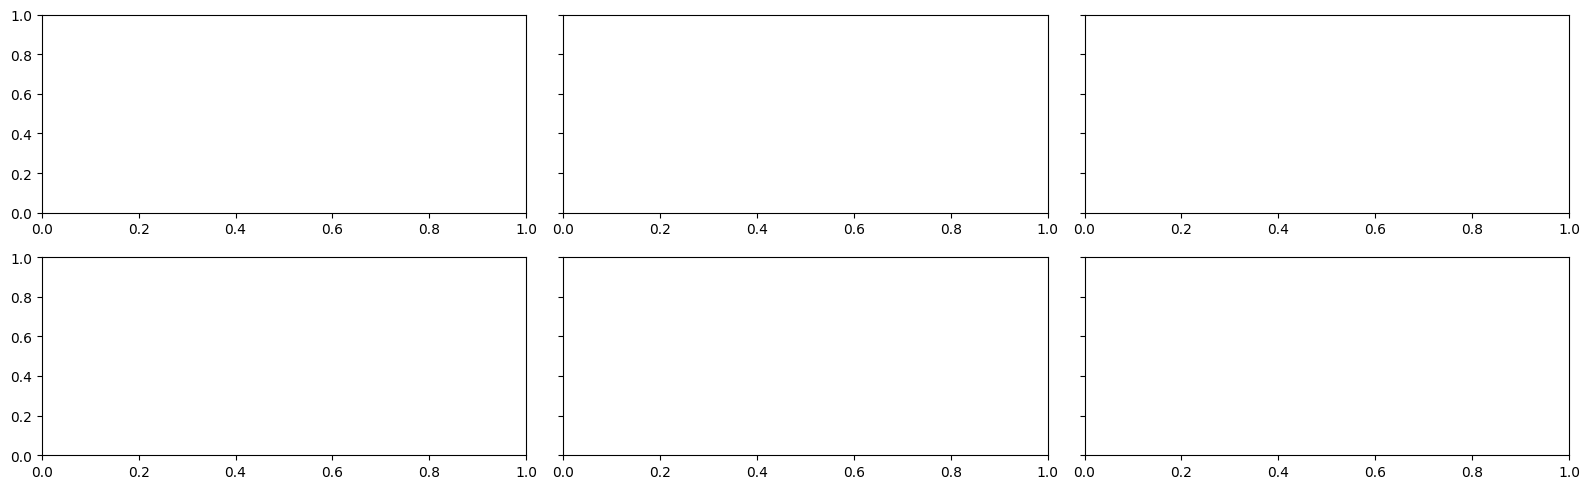

In [163]:
# The "Future" figure with twin axes and rotated x-labels
fig, axes = plt.subplots(2, 3, figsize=(16, 5), sharey=True)
axes_top = axes[0]  # Top row
axes_bot = axes[1]  # Bottom row

for i, (param,  in enumerate(zip(aggregated.keys, best_results.keys)):

    if i > axes.shape[0]:
        break
    
    keys = list(data[param].keys())
    min_rwps = [np.min(data[param]["agg"][k]["rwp"]) for k in keys]

    ax = axes_top[i]
    ax.plot(data[param]["best"]["pxrd_ref"]["iq"])

    ax = axes_bot[i]
    ax.plot(keys, min_rwps, label="Min Rwp", color="C0")

    ax.set_xlabel(param)
    
    if i == 0:
        ax.set_ylabel("Min Rwp", color="C0")

    # Rotate x-axis labels for readability
    ax.set_xticks(keys)
    ax.set_xticklabels(keys, rotation=90, ha="center")

fig.tight_layout()
plt.show()

In [ ]:
# plt.plot(params, rwps)
plt.plot(params, best_rwps)

In [36]:
def the_figure(result_path):
    # Load data
    with open(result_path, "rb") as f:
        data = pickle.load(f)
    results = data["results"]
    default_params_dict = data["config"]["default_params_dict"]
    params_dict = data["config"]["params_dict"]

    # The "Future" figure
    fig, axes = plt.subplots(2, 8, figsize=(16,5), sharey=True)

    axes_top = axes[0,:]
    axes_bot = axes[1,:]

    fig.tight_layout()
    plt.show()

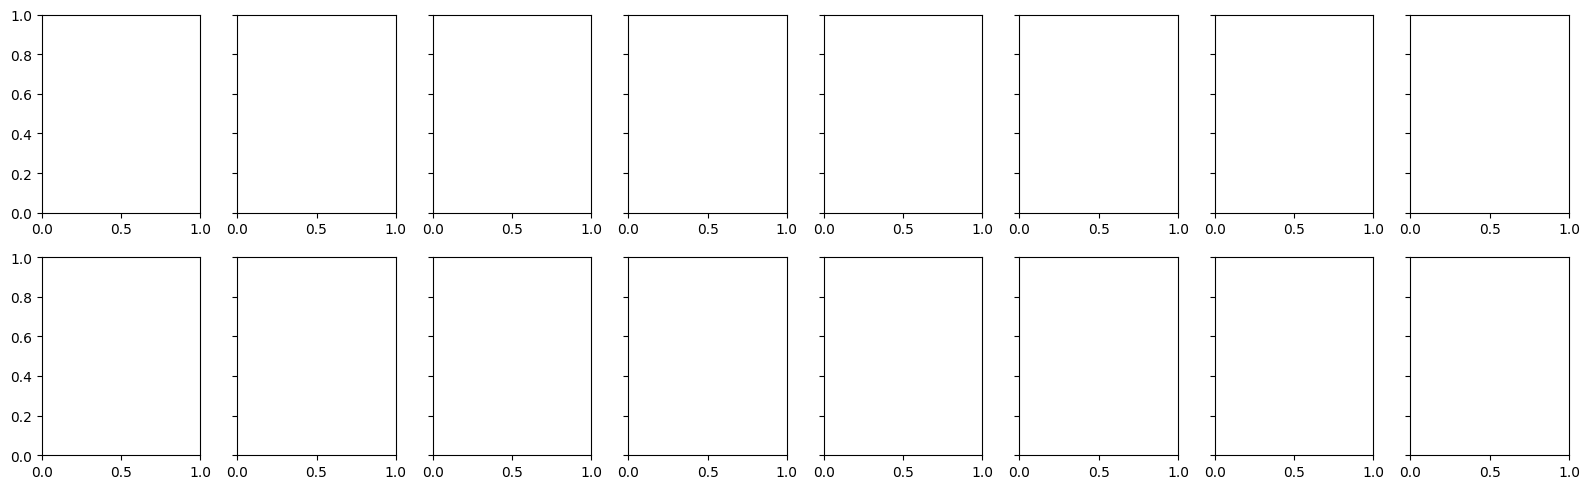

In [37]:
the_figure("../ablation_results_comp.pkl")

{'qmin': 0.0, 'qmax': 10.0, 'qstep': 0.01, 'base_fwhm': 0.05, 'eta': 0.5}
{'chebychev_order': 6}


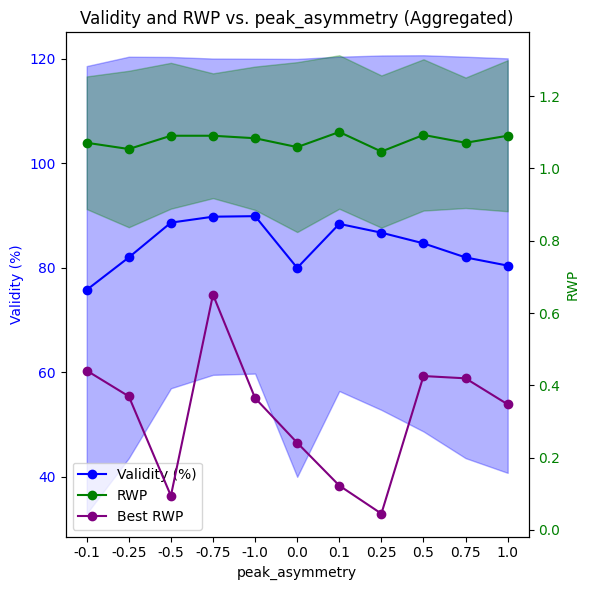

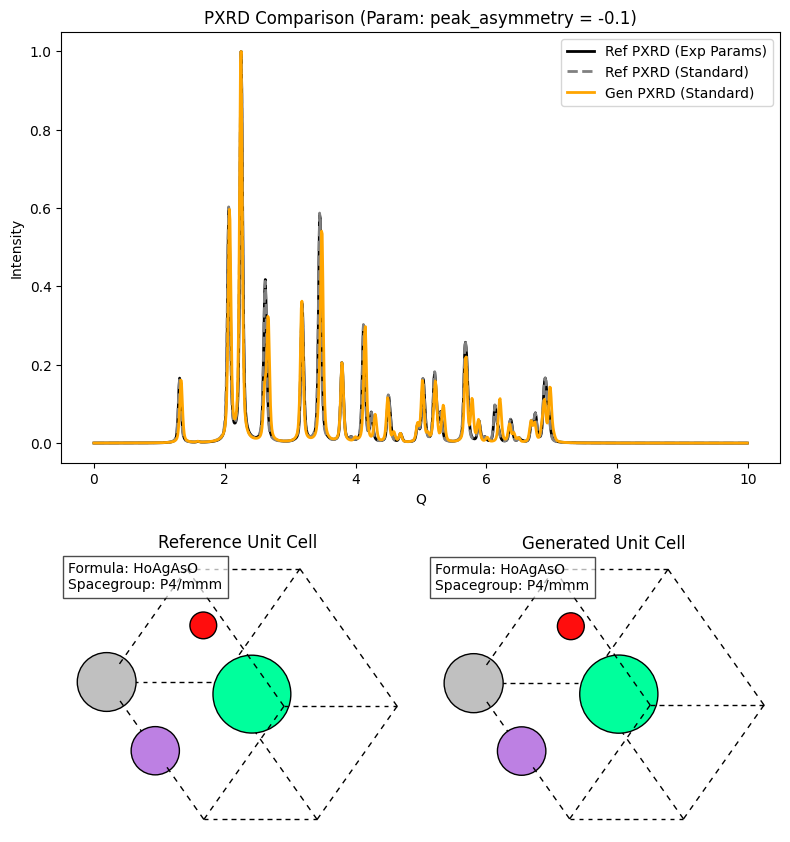

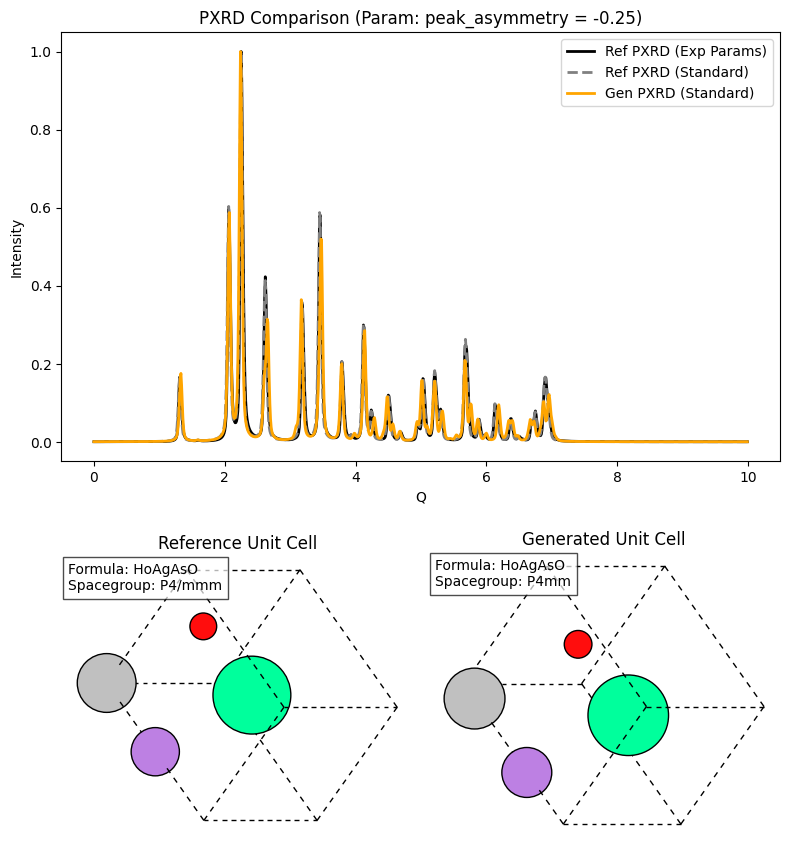

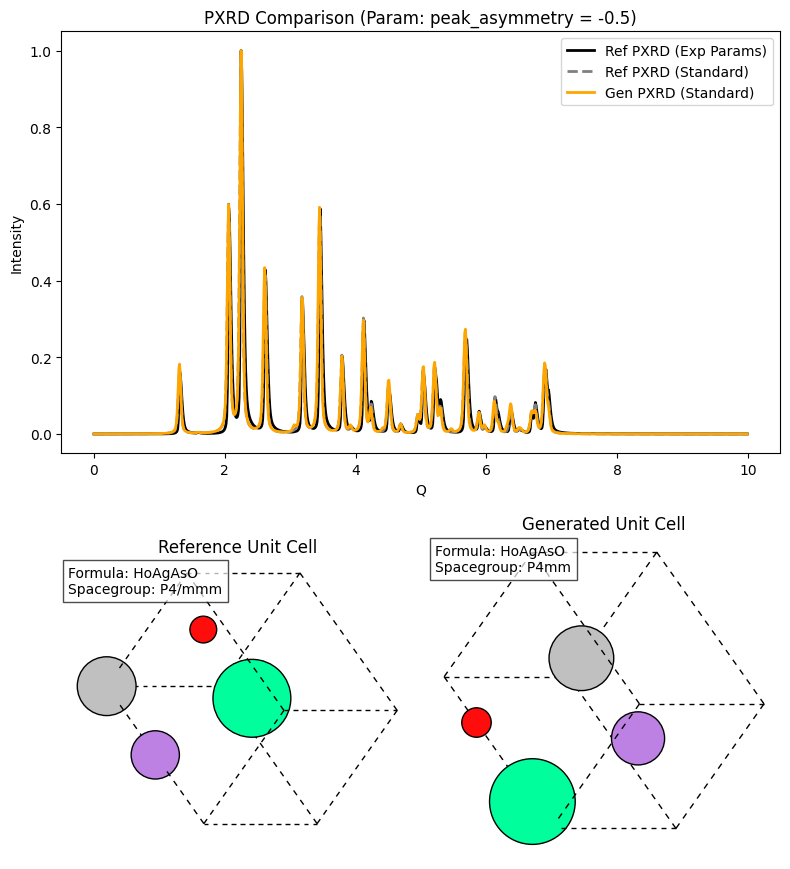

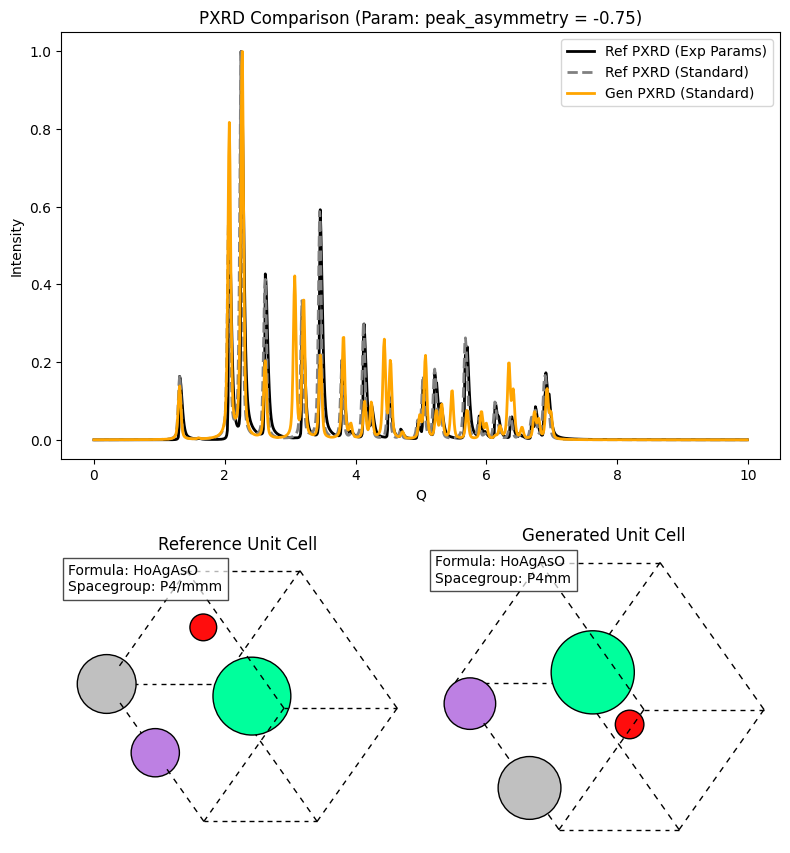

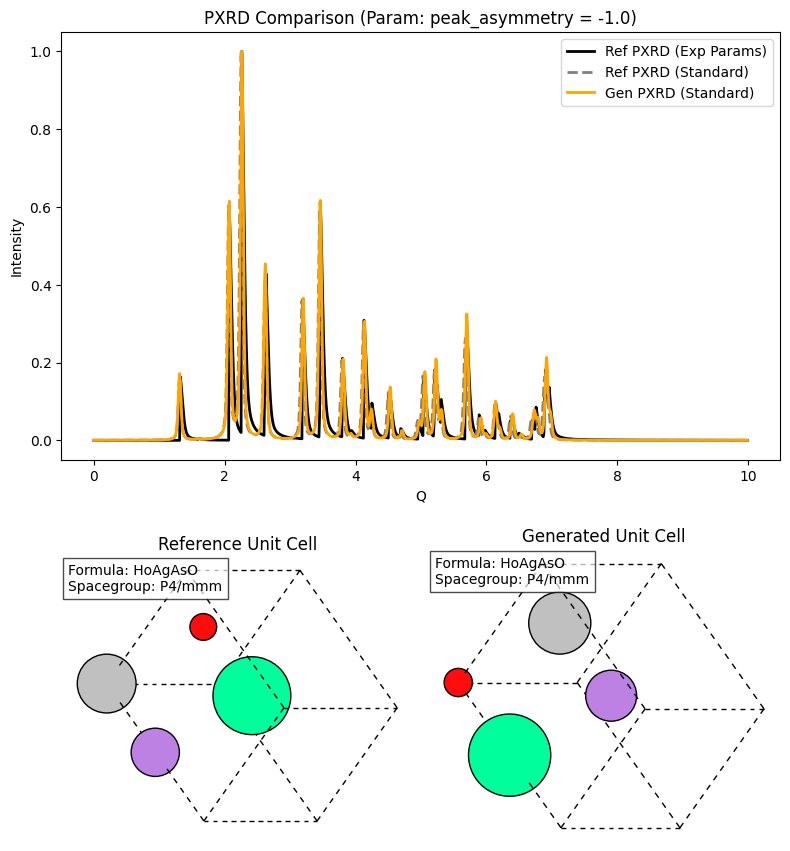

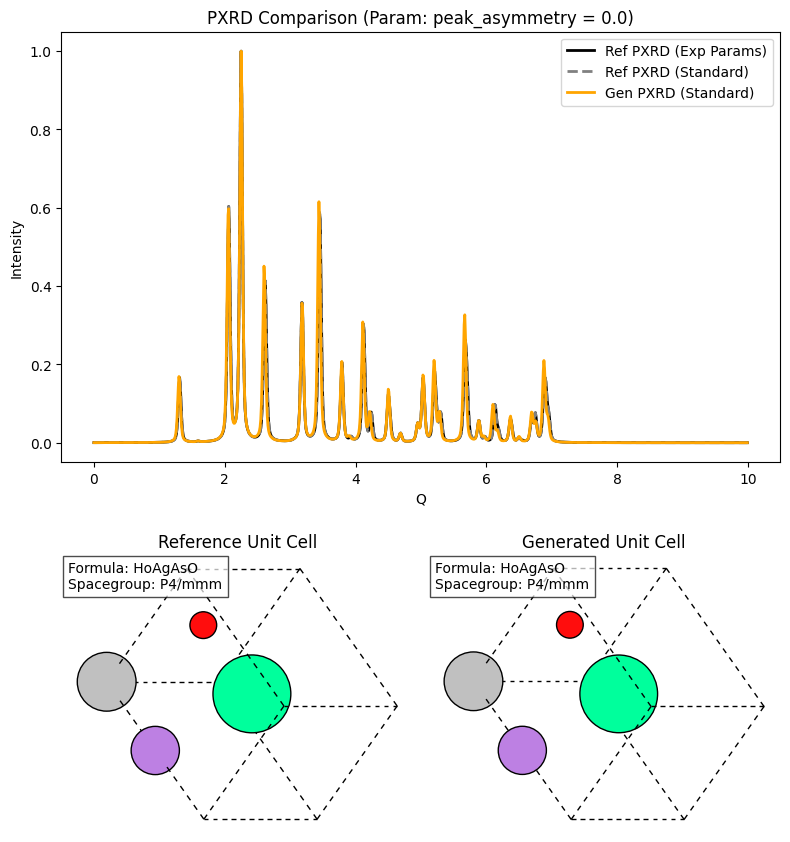

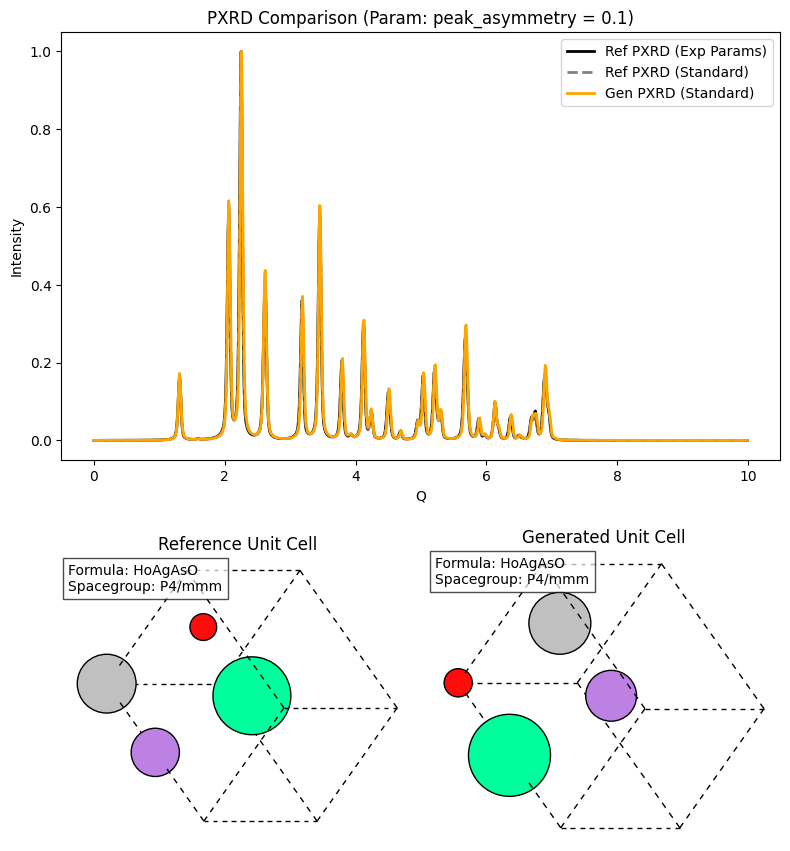

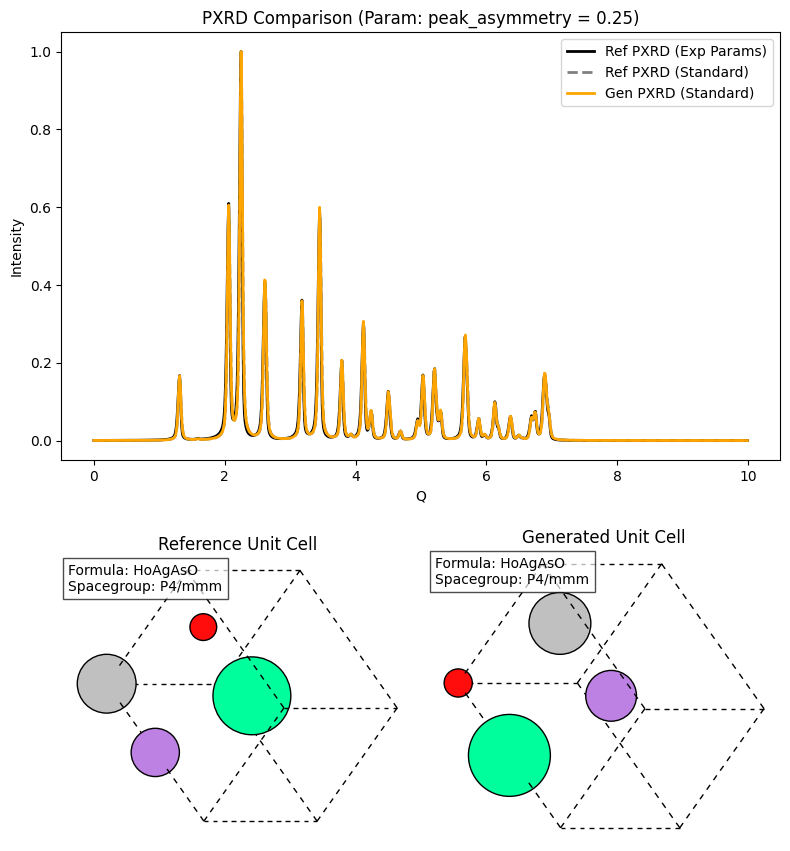

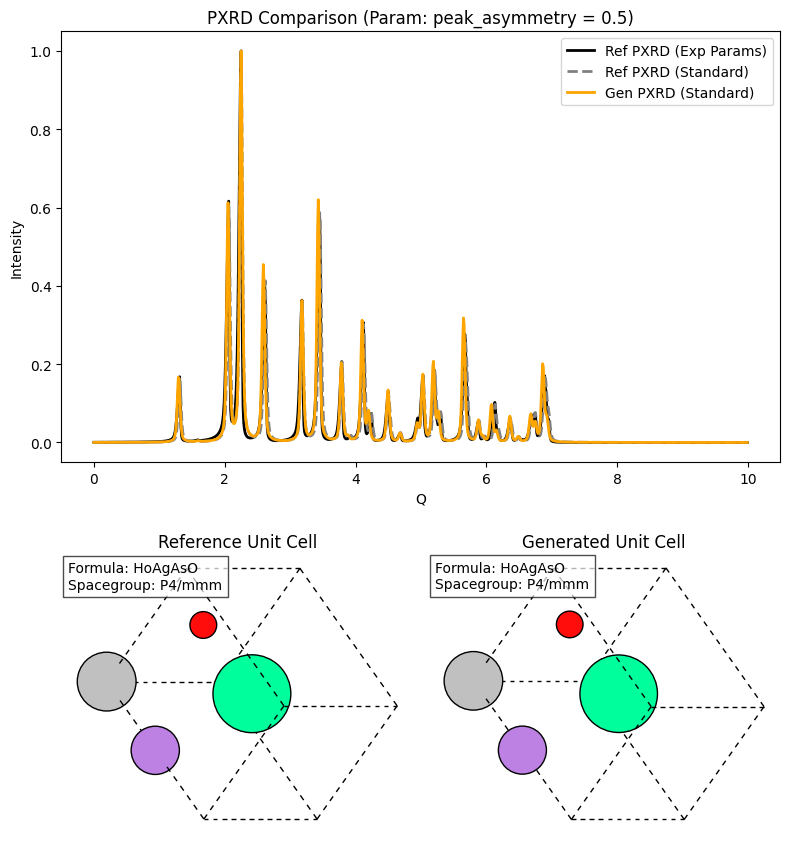

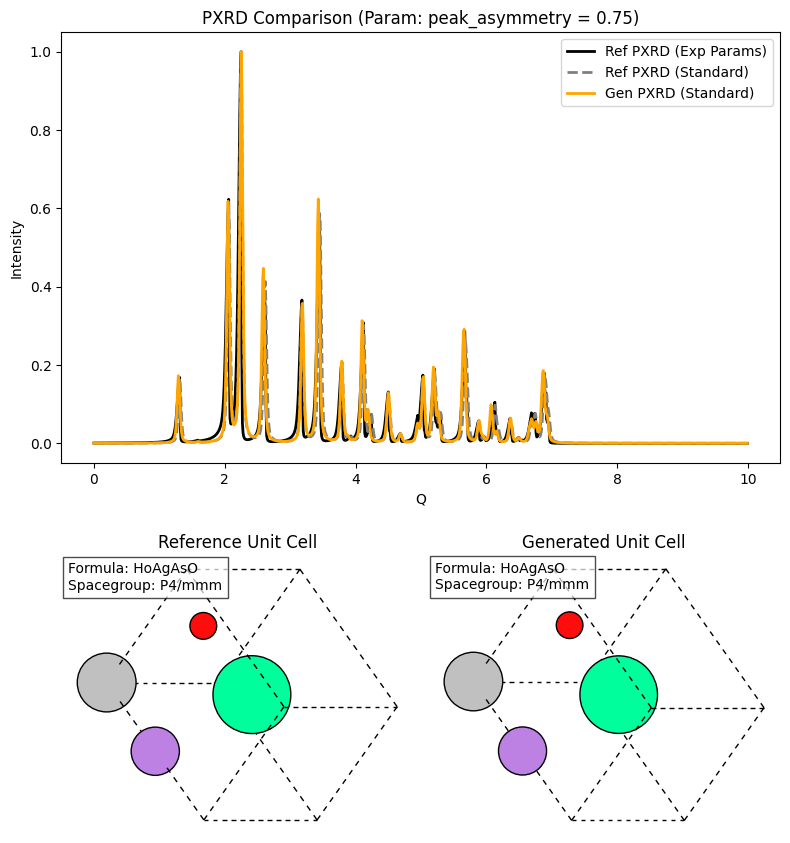

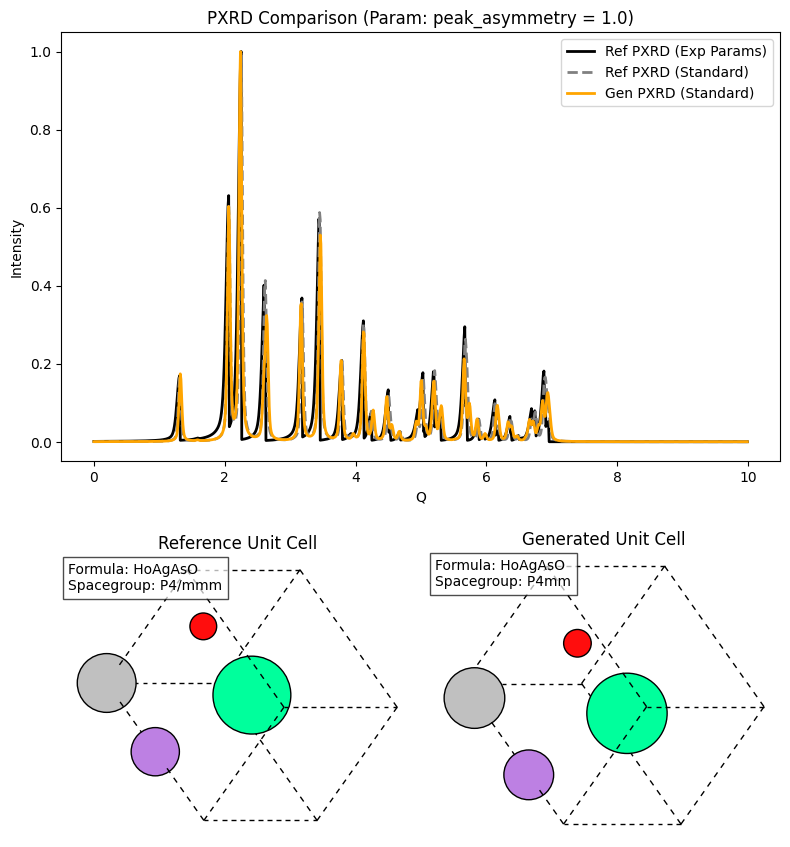

In [15]:
combined_analysis_and_visualization("../ablation_results_comp.pkl",
                                    "peak_asymmetry", prefix="comp", folder="ablation")

In [128]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from decifer.utility import pxrd_from_cif
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms
import matplotlib.patheffects as path_effects

# Load data
with open('../ablation_results_cubic_comp.pkl', "rb") as f:
    data = pickle.load(f)
results = data["results"]
default_params_dict = data["config"]["default_params_dict"]

In [350]:
def plot_unit_cell_with_boundaries(structure, tol=1e-5, radii=0.8, rotation=('45x, -15y, 90z')):
    """
    Plots the unit cell along with the image atoms from neighboring cells that are exactly on 
    the unit cell boundary (in the positive x, y, and z directions). Returns a matplotlib axis 
    that can be inserted into a figure's subplots.

    Parameters:
        structure (pymatgen.core.structure.Structure): The input structure.
        tol (float): Tolerance for determining if an atom's fractional coordinate is on the boundary.
        radii (float): Radii for visualizing atoms.
        rotation (tuple or str): Rotation settings for the plot_atoms function.

    Returns:
        ax: The matplotlib axis containing the plotted structure.
    """
    from pymatgen.io.ase import AseAtomsAdaptor
    from pymatgen.core import Structure as PMGStructure
    import numpy as np
    import matplotlib.pyplot as plt
    from ase.visualize.plot import plot_atoms

    # Define translation vectors for the original cell and its neighboring cells in the positive directions.
    translation_vectors = [
        [0, 0, 0],  # Original cell
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 1]
    ]
    
    all_species = []
    all_coords = []
    
    # Loop over each translation vector.
    for tv in translation_vectors:
        tv_cart = structure.lattice.get_cartesian_coords(tv)
        for site in structure:
            if tv == [0, 0, 0]:
                all_species.append(site.species_string)
                all_coords.append(site.coords)
            else:
                # For neighboring cells, include only those atoms whose fractional coordinates 
                # are on the boundary (i.e. near 0) in each direction that is shifted.
                if all(site.frac_coords[i] < tol for i, shift in enumerate(tv) if shift == 1):
                    all_species.append(site.species_string)
                    all_coords.append(site.coords + tv_cart)
    
    all_coords = np.array(all_coords)
    
    # Build a bounding box that encloses the collected atoms.
    min_coords = all_coords.min(axis=0)
    max_coords = all_coords.max(axis=0)
    lattice_vectors = np.diag(max_coords - min_coords)
    
    discrete_structure = PMGStructure(
        lattice=lattice_vectors,
        species=all_species,
        coords=all_coords,
        coords_are_cartesian=True
    )
    
    # Convert the discrete pymatgen structure to an ASE Atoms object and remove periodic boundaries.
    ase_atoms = AseAtomsAdaptor.get_atoms(discrete_structure)
    ase_atoms.set_pbc([False, False, False])
    
    # Create a new figure and axis for plotting.
    fig, ax = plt.subplots()
    plot_atoms(ase_atoms, ax, radii=radii, show_unit_cell=True, rotation=rotation)
    
    return ax


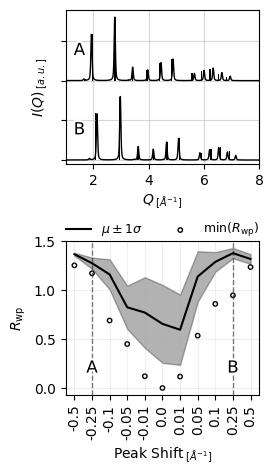

In [195]:
fig, (ax, ax_t) = plt.subplots(2,1,figsize=(2.5,5))

param_key = "q_shift"
param_key_xlabel = "Peak Shift"
param_key_unit = r"$_{\;[Å^{-1}]}$"
example_1_key = "-0.1"
example_2_key = "0.1"

q_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
iq_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
q_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
iq_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]

q_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
iq_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
q_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
iq_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]

peak_scaling = 0.8

ax.plot(q_1, iq_1*peak_scaling, lw=1, c='k')
ax.plot(q_100, iq_100*peak_scaling-1, lw=1, c='k')

ax.bar(q_1_disc, iq_1_disc / 100*peak_scaling, width=0.05, color='k')
ax.bar(q_100_disc, iq_100_disc / 100*peak_scaling, bottom=-1, width=0.05, color='k')
 
ax.grid(alpha=0.5)
ax.set(
    yticklabels=[],
    xlabel = r"$Q_{\;[Å^{-1}]}$",
    ylabel = r"$I(Q)_{\;[a.u.]}$",
    ylim=(-1.05, None),
    xlim=(1,8),
)

ax.text(1.5, .5, "A", ha='center', va='top', fontsize=12, color='black',
          path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ax.text(1.5, -.5, "B", ha='center', va='top', fontsize=12, color='black',
          path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

param_val_keys = results[param_key].keys()

min_rwps = np.array([results[param_key][key]["best_experiment"]["rwp"] for key in param_val_keys])
mean_rwps = np.array([np.mean([l["rwp"] for l in  results[param_key][key]["experiments"]]) for key in param_val_keys])
std_rwps = np.array([np.std([l["rwp"] for l in  results[param_key][key]["experiments"]]) for key in param_val_keys])

ax_t.plot(param_val_keys, mean_rwps, label=r"$\mu \pm 1\sigma$", color="k")
ax_t.scatter(param_val_keys, min_rwps, label="$\mathrm{min}(R_{\mathrm{wp}}$)", color="k", s=10, fc='none')
ax_t.fill_between(param_val_keys, mean_rwps - std_rwps, mean_rwps + std_rwps, color='k', alpha=0.3)

ax_t.axvline(1, c='k', lw='1', ls='--', alpha=0.5)
ax_t.axvline(9, c='k', lw='1', ls='--', alpha=0.5)

ax_t.grid(alpha=0.2, which='major')

letter_pos = 0.2
y_top = ax_t.get_ylim()[1]
ax_t.text(1, y_top * letter_pos, "A", ha='center', va='top', fontsize=12, color='black',
          path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ax_t.text(9, y_top * letter_pos, "B", ha='center', va='top', fontsize=12, color='black',
          path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

ax_t.set(
    ylabel=r'$R_{\mathrm{wp}}$',
    xlabel=f'{param_key_xlabel}' + f'{param_key_unit}'
)
ax_t.set_xticks(list(param_val_keys))  # Ensure ticks match the keys
ax_t.set_xticklabels([str(k) for k in param_val_keys], rotation=90)  # Rotate labels

# ax_t.legend(fontsize=8, loc='upper center')
ax_t.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=False)

fig.subplots_adjust(hspace=0.5)  # Increase space between subplots
plt.show()

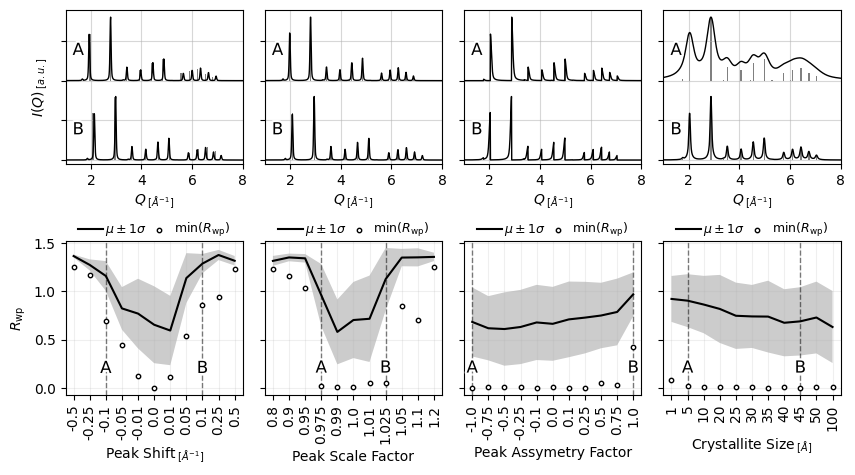

In [262]:
# Define your list of parameter dictionaries.
# You can add more parameters to this list as needed.
param_keys = [
    {"key": "q_shift", "xlabel": "Peak Shift", "unit": r"$_{\;[Å^{-1}]}$", "example_1_idx": 2, "example_2_idx": 8},
    {"key": "q_scale",  "xlabel": "Peak Scale Factor", "unit": "", "example_1_idx": 3, "example_2_idx": 7},
    {"key": "peak_asymmetry",  "xlabel": "Peak Assymetry Factor", "unit": "", "example_1_idx": 0, "example_2_idx": 10},
    {"key": "particle_size",  "xlabel": "Crystallite Size", "unit": r"$_{\;[Å]}$", "example_1_idx": 1, "example_2_idx": 8},
]

n_params = len(param_keys)
fig, axes = plt.subplots(2, n_params, figsize=(2.5 * n_params, 5), squeeze=False, sharey='row')

# Loop through each parameter and plot in its respective column.
for i, param in enumerate(param_keys):
    
    param_key = param["key"]
    param_key_xlabel = param["xlabel"]
    param_key_unit = param["unit"]

    param_val_keys = list(results[param_key].keys())
    example_1_idx = param["example_1_idx"]
    example_2_idx = param["example_2_idx"]
    example_1_key = param_val_keys[example_1_idx]
    example_2_key = param_val_keys[example_2_idx]
    
    # Extract data for example 1
    q_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
    iq_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
    q_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
    iq_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
    # Extract data for example 2
    q_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
    iq_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
    q_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
    iq_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
    peak_scaling = 0.8
    
    # Top subplot: main plot for current parameter.
    ax = axes[0, i]
    ax.plot(q_1, iq_1 * peak_scaling, lw=1, c='k')
    ax.plot(q_100, iq_100 * peak_scaling - 1, lw=1, c='k')
    
    ax.bar(q_1_disc, iq_1_disc / 100 * peak_scaling, width=0.05, color='grey')
    ax.bar(q_100_disc, iq_100_disc / 100 * peak_scaling, bottom=-1, width=0.05, color='grey')
    
    ax.grid(alpha=0.5)
    ax.set(
        yticklabels=[],
        xlabel=r"$Q_{\;[Å^{-1}]}$",
        ylabel=r"$I(Q)_{\;[a.u.]}$" if i == 0 else "",  # Label only the first column for clarity
        ylim=(-1.05, None),
        xlim=(1, 8),
    )
    
    ax.text(1.5, 0.5, "A", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax.text(1.5, -0.5, "B", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    # Bottom subplot: trend plot for current parameter.
    ax_t = axes[1, i]
    
    # Optionally, sort the keys if they represent numeric values:
    # param_val_keys = sorted(param_val_keys, key=lambda x: float(x))
    
    min_rwps = np.array([results[param_key][key]["best_experiment"]["rwp"] for key in param_val_keys])
    mean_rwps = np.array([np.mean([l["rwp"] for l in results[param_key][key]["experiments"]])
                            for key in param_val_keys])
    std_rwps = np.array([np.std([l["rwp"] for l in results[param_key][key]["experiments"]])
                           for key in param_val_keys])
    
    ax_t.plot(param_val_keys, mean_rwps, label=r"$\mu \pm 1\sigma$", color="k")
    ax_t.scatter(param_val_keys, min_rwps, label="$\mathrm{min}(R_{\mathrm{wp}})$", color="k", s=10, fc='white', zorder=100)
    ax_t.fill_between(param_val_keys, mean_rwps - std_rwps, mean_rwps + std_rwps, color='k', alpha=0.2, ec='none')

    ax_t.axvline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5)
    ax_t.axvline(example_2_idx, c='k', lw=1, ls='--', alpha=0.5)
    ax_t.grid(alpha=0.2, which='major')
    
    letter_pos = 0.2
    y_top = ax_t.get_ylim()[1]
    ax_t.text(example_1_idx, y_top * letter_pos, "A", ha='center', va='top', fontsize=12, color='black',
              path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax_t.text(example_2_idx, y_top * letter_pos, "B", ha='center', va='top', fontsize=12, color='black',
              path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_t.set(
        ylabel=r'$R_{\mathrm{wp}}$' if i == 0 else "",
        xlabel=f'{param_key_xlabel}{param_key_unit}'
    )
    ax_t.set_xticks(list(param_val_keys))
    ax_t.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
    ax_t.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=False, columnspacing=0.0, handletextpad=0.15)

fig.subplots_adjust(hspace=0.5, wspace=0.125)
plt.show()


In [483]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting (if needed)
from ase.visualize.plot import plot_atoms
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure as PMGStructure
import matplotlib.patheffects as path_effects

def plot_unit_cell_with_boundaries(structure, ax=None, tol=1e-5, radii=0.8, rotation=('45x, -15y, 90z'), offset=(0, 0, 0)):
    """
    Plots the unit cell along with image atoms from neighboring cells (in the positive x, y, and z directions)
    that are exactly on the unit cell boundary onto a provided axis.
    
    Parameters:
        structure (pymatgen.core.structure.Structure): The input structure.
        ax (matplotlib.axes.Axes): Axis to plot on. If None, a new axis is created.
        tol (float): Tolerance for determining if an atom's fractional coordinate is on the boundary.
        radii (float): Radii for visualizing atoms.
        rotation (tuple or str): Rotation settings for the plot_atoms function.
        
    Returns:
        (ax, discrete_structure): The matplotlib axis containing the plotted structure 
            and the discrete pymatgen Structure constructed.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # Define translation vectors for the original cell and its neighboring cells in the positive directions.
    translation_vectors = [
        [0, 0, 0],  # Original cell
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 1]
    ]
    
    all_species = []
    all_coords = []
    
    # Loop over each translation vector.
    for tv in translation_vectors:
        tv_cart = structure.lattice.get_cartesian_coords(tv)
        for site in structure:
            if tv == [0, 0, 0]:
                # For the original cell, include all atoms.
                all_species.append(site.species_string)
                all_coords.append(site.coords)
            else:
                # For neighboring cells, include only atoms on the cell boundary
                # (i.e. the atom's fractional coordinate is nearly zero in each shifted direction).
                if all(site.frac_coords[i] < tol for i, shift in enumerate(tv) if shift == 1):
                    all_species.append(site.species_string)
                    all_coords.append(site.coords + tv_cart)
    
    all_coords = np.array(all_coords)
    
    # Build a bounding box that encloses the collected atoms.
    min_coords = all_coords.min(axis=0)
    max_coords = all_coords.max(axis=0)
    lattice_vectors = np.diag(max_coords - min_coords)
    
    discrete_structure = PMGStructure(
        lattice=lattice_vectors,
        species=all_species,
        coords=all_coords,
        coords_are_cartesian=True
    )
    
    # Convert the discrete pymatgen structure to an ASE Atoms object and remove periodic boundaries.
    ase_atoms = AseAtomsAdaptor.get_atoms(discrete_structure)
    ase_atoms.set_pbc([False, False, False])
    
    # Plot onto the provided axis.
    plot_atoms(ase_atoms, ax, radii=radii, show_unit_cell=True, rotation=rotation, offset=offset)
    
    return ax, discrete_structure

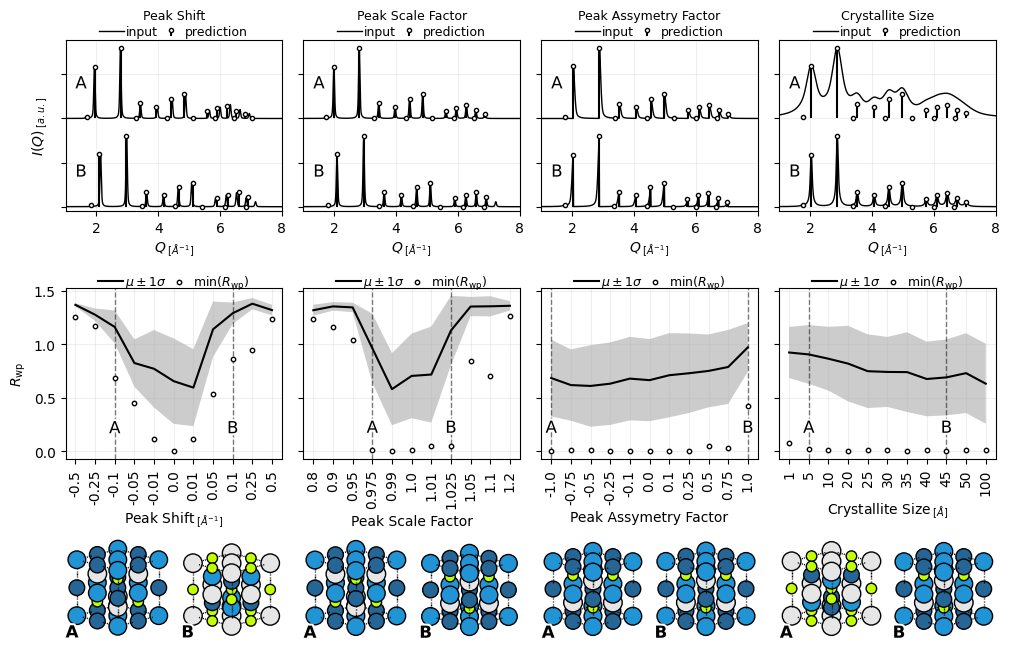

In [560]:
# Define your list of parameter dictionaries.
param_keys = [
    {"key": "q_shift", "xlabel": "Peak Shift", "unit": r"$_{\;[Å^{-1}]}$", "example_1_idx": 2, "example_2_idx": 8},
    {"key": "q_scale",  "xlabel": "Peak Scale Factor", "unit": "", "example_1_idx": 3, "example_2_idx": 7},
    {"key": "peak_asymmetry", "xlabel": "Peak Assymetry Factor", "unit": "", "example_1_idx": 0, "example_2_idx": 10},
    {"key": "particle_size", "xlabel": "Crystallite Size", "unit": r"$_{\;[Å]}$", "example_1_idx": 1, "example_2_idx": 8},
]

# Colors
c_ex1 = "k"#"C1"
c_ex2 = "k"#"C2"
c_pred1 = "grey"
c_pred2 = "grey"
c_trend = "k"#"C3"

# Other
pred_marker_size = 3
fig_width_factor = 3

n_params = len(param_keys)
# Create a subplot grid with 3 rows:
# Row 0: main plot; Row 1: trend plot; Rows 2: unit cell plots for example A
# Use height_ratios so that rows 2 and 3 are half the height of rows 0 and 1.
fig, axes = plt.subplots(3, n_params, figsize=(fig_width_factor * n_params, 8), squeeze=False,
                          sharey='row', gridspec_kw={'height_ratios': [1, 1, 0.7]})

for i, param in enumerate(param_keys):
    param_key = param["key"]
    param_key_xlabel = param["xlabel"]
    param_key_unit = param["unit"]

    param_val_keys = list(results[param_key].keys())
    example_1_idx = param["example_1_idx"]
    example_2_idx = param["example_2_idx"]
    example_1_key = param_val_keys[example_1_idx]
    example_2_key = param_val_keys[example_2_idx]
    
    # --- Top subplot: main plot for current parameter.
    ax = axes[0, i]
    # Extract data for example 1 (A)
    q_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
    iq_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
    q_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
    iq_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
    # Extract data for example 2 (B)
    q_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
    iq_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
    q_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
    iq_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
    peak_scaling = 0.8
    ax.plot(q_1, iq_1 * peak_scaling, lw=1, c=c_ex1, label='input')
    ax.plot(q_100, iq_100 * peak_scaling - 1, lw=1, c=c_ex2)
    
    #ax.bar(q_1_disc, iq_1_disc / 100 * peak_scaling, width=pred_width, color=c_pred1, zorder=10, label='pred. 1', hatch='..', edgecolor='none')
    #ax.bar(q_100_disc, iq_100_disc / 100 * peak_scaling, bottom=-1, width=pred_width, color=c_pred2, zorder=10, label='pred. 2', hatch='..', edgecolor='none')

    stem = ax.stem(q_1_disc,  iq_1_disc / 100 * peak_scaling, linefmt='k-', markerfmt='ko', basefmt=' ', label='prediction')  # 'k' for black color
    stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor='k', markeredgewidth=1.0)
    stem.markerline.set_xdata(q_1_disc)

    stem = ax.stem(q_100_disc, iq_100_disc / 100 * peak_scaling - 1, linefmt='k-', markerfmt='ko', basefmt=' ', bottom=-1)  # 'k' for black color
    stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white', markeredgecolor='k', markeredgewidth=1.0)
    stem.markerline.set_xdata(q_100_disc)
    
    ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3,
                frameon=False, columnspacing=0.0, handletextpad=0.15)
    
    ax.grid(alpha=0.2)
    ax.set(
        yticklabels=[],
        xlabel=r"$Q_{\;[Å^{-1}]}$",
        ylabel=r"$I(Q)_{\;[a.u.]}$" if i == 0 else "",
        ylim=(-1.05, None),
        xlim=(1, 8),
    )

    ax.set_title(param_key_xlabel, pad=15.0, fontsize=9)
    
    ax.text(1.5, 0.5, "A", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax.text(1.5, -0.5, "B", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    # --- Second subplot: trend plot for current parameter.
    ax_t = axes[1, i]
    min_rwps = np.array([results[param_key][key]["best_experiment"]["rwp"] for key in param_val_keys])
    mean_rwps = np.array([np.mean([l["rwp"] for l in results[param_key][key]["experiments"]])
                            for key in param_val_keys])
    std_rwps = np.array([np.std([l["rwp"] for l in results[param_key][key]["experiments"]])
                           for key in param_val_keys])
    
    ax_t.plot(param_val_keys, mean_rwps, label=r"$\mu \pm 1\sigma$", color=c_trend)
    ax_t.scatter(param_val_keys, min_rwps, label="$\mathrm{min}(R_{\mathrm{wp}})$", color=c_trend, s=10, fc='white', zorder=10)
    ax_t.fill_between(param_val_keys, mean_rwps - std_rwps, mean_rwps + std_rwps,
                      color=c_trend, alpha=0.2, ec='none')
    
    ax_t.axvline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5) 
    ax_t.axvline(example_2_idx, c='k', lw=1,ls='--', alpha=0.5) 
    ax_t.grid(alpha=0.2, which='major')
    
    letter_pos = 0.2
    y_top = ax_t.get_ylim()[1]
    ax_t.text(example_1_idx, y_top * letter_pos, "A", ha='center', va='top', fontsize=12, color='black',
              path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax_t.text(example_2_idx, y_top * letter_pos, "B", ha='center', va='top', fontsize=12, color='black',
              path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_t.set(
        ylabel=r'$R_{\mathrm{wp}}$' if i == 0 else "",
        xlabel=f'{param_key_xlabel}{param_key_unit}'
    )
    ax_t.set_xticks(list(param_val_keys))
    ax_t.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
    ax_t.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2,
                frameon=False, columnspacing=0.0, handletextpad=0.15)
    
    # --- Third subplot (row 2): Unit cell plot including both structures A and B
    structure_A = results[param_key][example_1_key]["best_experiment"]["generated_structure"]
    structure_B = results[param_key][example_2_key]["best_experiment"]["generated_structure"]
    
    ax_cell = axes[2, i]
    # Plot structure A with no offset.
    ax_cell, discrete_structure_A = plot_unit_cell_with_boundaries(structure_A, ax=ax_cell)
    
    # Compute an offset for structure B based on structure A's lattice parameter.
    a_A, _, _ = discrete_structure_A.lattice.abc
    offset_B = (a_A * 2, 0, 0)
    
    # Plot structure B on the same axis with the computed offset.
    ax_cell, discrete_structure_B = plot_unit_cell_with_boundaries(structure_B, ax=ax_cell, offset=offset_B)
    
    # Add text labels at appropriate data coordinates.
    ax_cell.text(0, 0, "A", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax_cell.text(offset_B[0], 0, "B", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_cell.set_ylim(-2, discrete_structure_B.cart_coords.max()*1.8)
    ax_cell.axis("off")

fig.subplots_adjust(hspace=0.5, wspace=0.1)
plt.show()


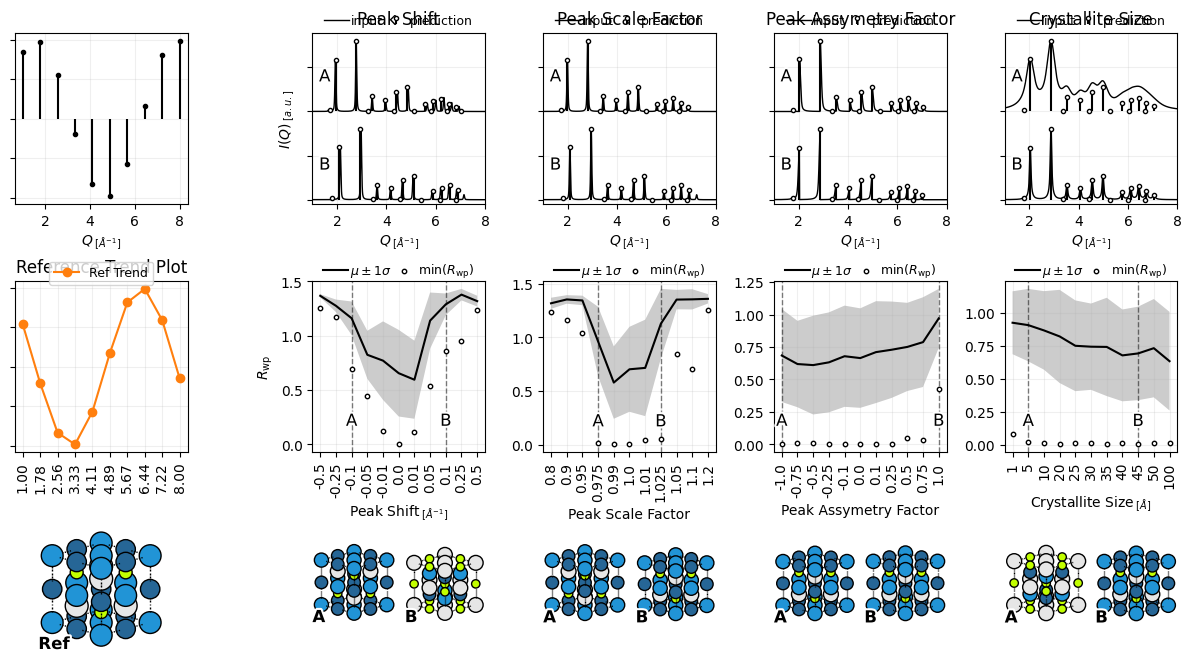

In [551]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting (if needed)
from ase.visualize.plot import plot_atoms
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure as PMGStructure
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec

# Define your list of parameter dictionaries.
param_keys = [
    {"key": "q_shift", "xlabel": "Peak Shift", "unit": r"$_{\;[Å^{-1}]}$", "example_1_idx": 2, "example_2_idx": 8},
    {"key": "q_scale",  "xlabel": "Peak Scale Factor", "unit": "", "example_1_idx": 3, "example_2_idx": 7},
    {"key": "peak_asymmetry", "xlabel": "Peak Assymetry Factor", "unit": "", "example_1_idx": 0, "example_2_idx": 10},
    {"key": "particle_size", "xlabel": "Crystallite Size", "unit": r"$_{\;[Å]}$", "example_1_idx": 1, "example_2_idx": 8},
]

# Colors
c_ex1 = "k"  # input
c_ex2 = "k"  # input
c_pred1 = "grey"
c_pred2 = "grey"
c_trend = "k"  # trend

# Other settings
pred_marker_size = 3
fig_width_factor = 3
n_params = len(param_keys)

# Create a GridSpec with an extra spacer column between the reference column and parameter columns.
gs_fig = plt.figure(figsize=(fig_width_factor * (n_params + 1), 8))
gs = gridspec.GridSpec(3, n_params + 2, figure=gs_fig,
                       height_ratios=[1, 1, 0.7],
                       width_ratios=[1, 0.05] + [1]*n_params
                      )

# ----------------------------
# Reference Column Axes
# ----------------------------
ax_ref_top = gs_fig.add_subplot(gs[0, 0])
ax_ref_trend = gs_fig.add_subplot(gs[1, 0])
ax_ref_cell = gs_fig.add_subplot(gs[2, 0])

# ----------------------------
# Parameter Columns Axes for Each Row
# ----------------------------
axes_top   = [gs_fig.add_subplot(gs[0, i+2]) for i in range(n_params)]
axes_trend = [gs_fig.add_subplot(gs[1, i+2]) for i in range(n_params)]
axes_cell  = [gs_fig.add_subplot(gs[2, i+2]) for i in range(n_params)]

# ============================
# Reference Column (First Column)
# ============================

# -- Top row: Reference stem plot.
x_ref = np.linspace(1, 8, 10)
y_ref = np.sin(x_ref)
stem_ref = ax_ref_top.stem(x_ref, y_ref, linefmt='k-', markerfmt='ko', basefmt=' ')
stem_ref.markerline.set_markersize(pred_marker_size)
ax_ref_top.grid(alpha=0.2)
ax_ref_top.set(yticklabels=[], xlabel=r"$Q_{\;[Å^{-1}]}$")

# -- Middle row: Additional reference trend plot.
ax_ref_trend.plot(x_ref, np.cos(x_ref), 'C1-o', label="Ref Trend")
ax_ref_trend.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.15))
ax_ref_trend.set_title("Reference Trend Plot")
ax_ref_trend.grid(alpha=0.2)
ax_ref_trend.set_xticks(x_ref)
ax_ref_trend.set_xticklabels([f"{val:.2f}" for val in x_ref], rotation=90)
ax_ref_trend.set(yticklabels=[])

# -- Bottom row: Reference structure.
ref_key = list(results[param_keys[0]["key"]].keys())[0]
reference_structure = results[param_keys[0]["key"]][ref_key]["best_experiment"]["reference_structure"]

ax_ref_cell, discrete_ref = plot_unit_cell_with_boundaries(reference_structure, ax=ax_ref_cell)
ax_ref_cell.text(0, 0, "Ref", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
ax_ref_cell.axis("off")

# ============================
# Loop over parameter keys for parameter columns.
# ============================
for i, param in enumerate(param_keys):
    param_key = param["key"]
    param_key_xlabel = param["xlabel"]
    param_key_unit = param["unit"]

    param_val_keys = list(results[param_key].keys())
    example_1_idx = param["example_1_idx"]
    example_2_idx = param["example_2_idx"]
    example_1_key = param_val_keys[example_1_idx]
    example_2_key = param_val_keys[example_2_idx]
    
    # --- Top subplot: Main plot for current parameter.
    ax = axes_top[i]
    q_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["q"]
    iq_1 = results[param_key][example_1_key]["best_experiment"]["pxrd_ref"]["iq"]
    q_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
    iq_1_disc = results[param_key][example_1_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    
    q_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["q"]
    iq_100 = results[param_key][example_2_key]["best_experiment"]["pxrd_ref"]["iq"]
    q_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
    iq_100_disc = results[param_key][example_2_key]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0]
    ,
    peak_scaling = 0.8
    ax.plot(q_1, iq_1 * peak_scaling, lw=1, c=c_ex1, label='input')
    ax.plot(q_100, iq_100 * peak_scaling - 1, lw=1, c=c_ex2)
    
    stem = ax.stem(q_1_disc, iq_1_disc / 100 * peak_scaling, linefmt='k-', markerfmt='ko', basefmt=' ', label='prediction')
    stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white',
                        markeredgecolor='k', markeredgewidth=1.0)
    stem.markerline.set_xdata(q_1_disc)

    stem = ax.stem(q_100_disc, iq_100_disc / 100 * peak_scaling - 1, linefmt='k-', markerfmt='ko', basefmt=' ', bottom=-1)
    stem.markerline.set(markersize=pred_marker_size, markerfacecolor='white',
                        markeredgecolor='k', markeredgewidth=1.0)
    stem.markerline.set_xdata(q_100_disc)
    
    ax.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.175), ncol=3,
              frameon=False, columnspacing=0.0, handletextpad=0.15)
    
    ax.grid(alpha=0.2)
    ax.set(yticklabels=[],
           xlabel=r"$Q_{\;[Å^{-1}]}$",
           ylabel=r"$I(Q)_{\;[a.u.]}$" if i == 0 else "",
           ylim=(-1.05, None),
           xlim=(1, 8),

          )
    
    ax.text(1.5, 0.5, "A", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax.text(1.5, -0.5, "B", ha='center', va='top', fontsize=12, color='black',
            path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    # --- Middle subplot: Trend plot for current parameter.
    ax_t = axes_trend[i]
    min_rwps = np.array([results[param_key][key]["best_experiment"]["rwp"] for key in param_val_keys])
    mean_rwps = np.array([np.mean([l["rwp"] for l in results[param_key][key]["experiments"]])
                           for key in param_val_keys])
    std_rwps = np.array([np.std([l["rwp"] for l in results[param_key][key]["experiments"]])
                          for key in param_val_keys])
    
    ax_t.plot(param_val_keys, mean_rwps, label=r"$\mu \pm 1\sigma$", color=c_trend)
    ax_t.scatter(param_val_keys, min_rwps, label="$\mathrm{min}(R_{\mathrm{wp}})$",
                 color=c_trend, s=10, fc='white', zorder=10)
    ax_t.fill_between(param_val_keys, mean_rwps - std_rwps, mean_rwps + std_rwps,
                      color=c_trend, alpha=0.2, ec='none')
    
    ax_t.axvline(example_1_idx, c='k', lw=1, ls='--', alpha=0.5)
    ax_t.axvline(example_2_idx, c='k', lw=1, ls='--', alpha=0.5)
    ax_t.grid(alpha=0.2, which='major')
    
    letter_pos = 0.2
    y_top = ax_t.get_ylim()[1]
    ax_t.text(example_1_idx, y_top * letter_pos, "A", ha='center', va='top', fontsize=12,
              color='black', path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax_t.text(example_2_idx, y_top * letter_pos, "B", ha='center', va='top', fontsize=12,
              color='black', path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_t.set(ylabel=r'$R_{\mathrm{wp}}$' if i == 0 else "",
             xlabel=f'{param_key_xlabel}{param_key_unit}')
    ax_t.set_xticks(list(param_val_keys))
    ax_t.set_xticklabels([str(k) for k in param_val_keys], rotation=90)
    ax_t.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 1.175), ncol=2,
                frameon=False, columnspacing=0.0, handletextpad=0.15)
    
    # --- Bottom subplot: Unit cell plot including both structures A and B.
    structure_A = results[param_key][example_1_key]["best_experiment"]["generated_structure"]
    structure_B = results[param_key][example_2_key]["best_experiment"]["generated_structure"]
    
    ax_cell = axes_cell[i]
    ax_cell, discrete_structure_A = plot_unit_cell_with_boundaries(structure_A, ax=ax_cell)
    a_A, _, _ = discrete_structure_A.lattice.abc
    offset_B = (a_A * 2, 0, 0)
    
    ax_cell, discrete_structure_B = plot_unit_cell_with_boundaries(structure_B, ax=ax_cell, offset=offset_B)
    
    ax_cell.text(0, 0, "A", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    ax_cell.text(offset_B[0], 0, "B", fontsize=12, fontweight='bold', color='black',
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
    
    ax_cell.set_ylim(-2, overall_max[1]*1.8)
    ax_cell.axis("off")
    
gs_fig.subplots_adjust(hspace=0.5, wspace=0.4)
# gs_fig.tight_layout()
plt.show()


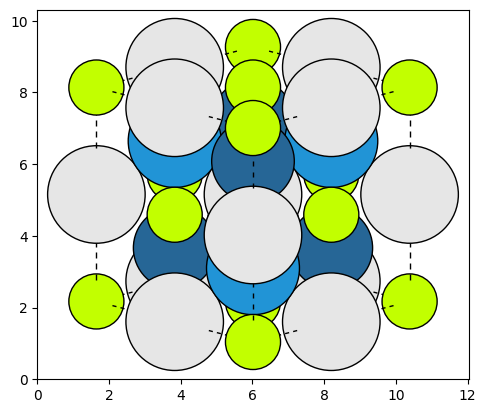

In [349]:
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from ase.visualize.plot import plot_atoms

# 1. Load the CIF file
structure = results["particle_size"]["100"]["best_experiment"]["generated_structure"]

# Define translation vectors for the original cell and its neighboring cells in the positive directions.
translation_vectors = [
    [0, 0, 0],  # Original cell
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 1]
]

tol = 1e-5  # Tolerance for checking if a fractional coordinate is effectively zero
all_species = []
all_coords = []

# Loop over each translation vector.
for tv in translation_vectors:
    tv_cart = structure.lattice.get_cartesian_coords(tv)
    for site in structure:
        # For the original cell, include all atoms.
        if tv == [0, 0, 0]:
            all_species.append(site.species_string)
            all_coords.append(site.coords)
        else:
            # For neighboring cells, include only those atoms whose fractional coordinates 
            # are on the boundary (i.e. near 0) in each direction that is shifted.
            if all(site.frac_coords[i] < tol for i, shift in enumerate(tv) if shift == 1):
                all_species.append(site.species_string)
                all_coords.append(site.coords + tv_cart)

all_coords = np.array(all_coords)

# Build a bounding box that encloses the collected atoms.
min_coords = all_coords.min(axis=0)
max_coords = all_coords.max(axis=0)
lattice_vectors = np.diag(max_coords - min_coords)

discrete_structure = Structure(
    lattice=lattice_vectors,
    species=all_species,
    coords=all_coords,
    coords_are_cartesian=True
)

# 6. Convert the discrete pymatgen structure to an ASE Atoms object and remove PBC.
ase_atoms = AseAtomsAdaptor.get_atoms(discrete_structure)
ase_atoms.set_pbc([False, False, False])

# Use ASE's plot_atoms function to visualize the structure.
fig, ax = plt.subplots()
plot_atoms(ase_atoms, ax, radii=0.8, show_unit_cell=True, rotation=('45x, -15y, 90z'))
plt.show()

In [329]:
view(ase_atoms)

<Popen: returncode: None args: ['/home/dev/miniconda3/envs/crystal/bin/pytho...>

In [265]:
import crystal_toolkit

In [275]:
from ase.visualize import view

In [276]:
view(results["particle_size"]["100"]["best_experiment"]["generated_structure"].to_ase_atoms())

<Popen: returncode: None args: ['/home/dev/miniconda3/envs/crystal/bin/pytho...>

In [277]:
results["particle_size"]["100"]["best_experiment"]["generated_structure"]

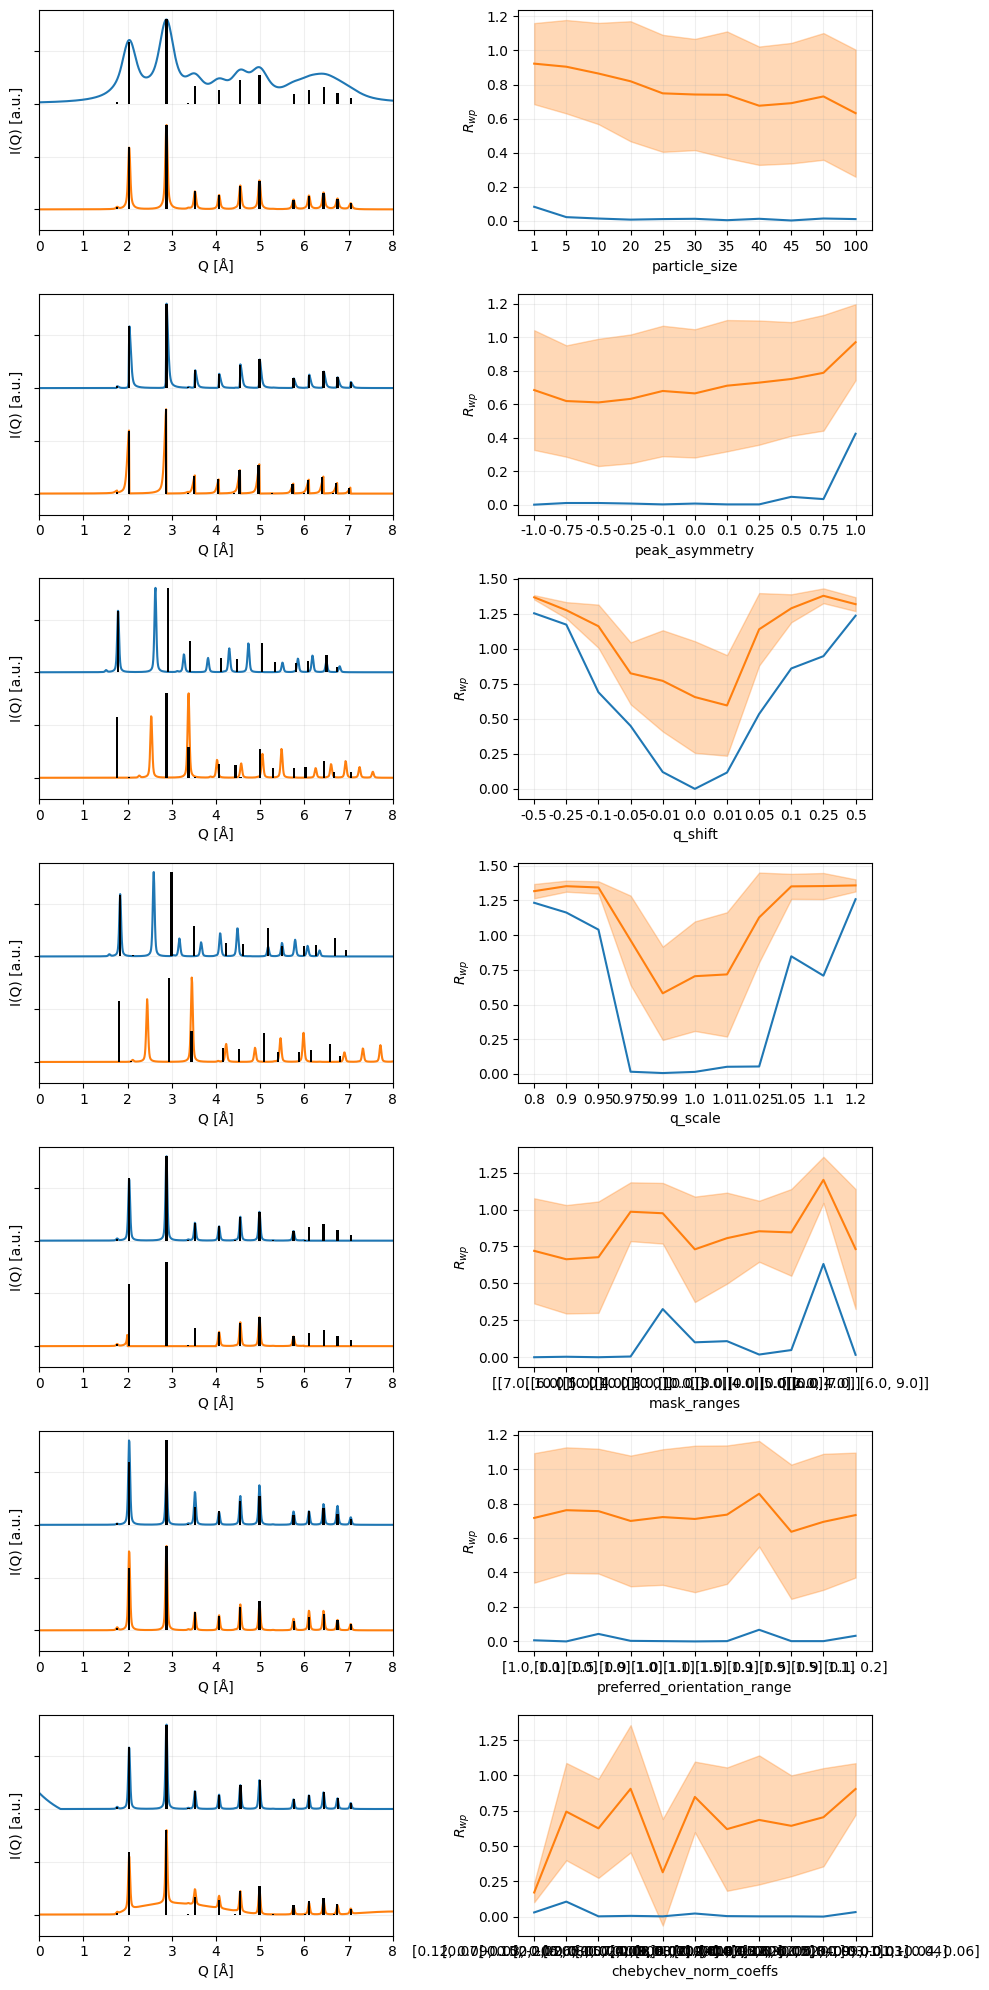

In [63]:
# The "Future" figure with twin axes and rotated x-labels
fig, axes = plt.subplots(7, 2, figsize=(10, 20))

for i, (param_key, param_val) in enumerate(results.items()):
    param_val_keys = list(param_val.keys())
    min_rwps = np.array([param_val[key]["best_experiment"]["rwp"] for key in param_val_keys])
    mean_rwps = np.array([np.mean([l["rwp"] for l in param_val[key]["experiments"]]) for key in param_val_keys])
    std_rwps = np.array([np.std([l["rwp"] for l in param_val[key]["experiments"]]) for key in param_val_keys])

    examples_indices = [1,-1]
    for j, ex in enumerate(examples_indices):
        k = param_val_keys[ex]
        q = param_val[k]["best_experiment"]["pxrd_ref"]["q"]
        iq = param_val[k]["best_experiment"]["pxrd_ref"]["iq"]
        p = axes[i,0].plot(q, iq*0.8-j, label=f"{param_key}: {k}")
        
        q = param_val[k]["best_experiment"]["pxrd_gen_clean"]["q_disc"][0]
        iq = param_val[k]["best_experiment"]["pxrd_gen_clean"]["iq_disc"][0] / 100
        
        axes[i,0].bar(x=q, height=iq*0.8, bottom=-j, width=0.05, color="k", zorder=100)
    
    axes[i,0].set(
        yticklabels=[],
        xlim=(0.0, 8.0),
        xlabel='Q [Å]',
        ylabel='I(Q) [a.u.]',
        ylim=(-1.2,None)
    )
    axes[i,0].grid(alpha=0.2)
    
    axes[i,1].plot(param_val_keys, min_rwps, label="Min Rwp", color="C0")
    axes[i,1].plot(param_val_keys, mean_rwps, label="Mean Rwp", color="C1")
    axes[i,1].fill_between(param_val_keys, mean_rwps - std_rwps, mean_rwps + std_rwps, color='C1', alpha=0.3)
    
    # axes[1,i].legend()
    axes[i,1].set(
        xlabel=param_key,
        # xticks=[],
        ylabel = r"$R_{wp}$"
    )
    axes[i,1].grid(alpha=0.2)
    # axes[1,i].legend()

fig.tight_layout()
plt.show()